In [1]:
import gc
import os
import torch
from pathlib import Path
import cv2
import numpy as np
import albumentations as A
import skimage.measure as km

import segmentation_models_pytorch as smp
from utils import *

c:\Users\sebge\miniconda3\envs\cuda-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ARCHITECTURE = smp.UnetPlusPlus
BACKBONE = 'se_resnext101_32x4d'
CLASSES = ['solar_panel']
activation = 'sigmoid'
EPOCHS = 25
n_classes = len(CLASSES)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE)

In [3]:
def get_model(model, backbone, n_classes, activation):
    return model(backbone, classes=n_classes, activation=activation)

def get_test_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(256, 256),
        A.PadIfNeeded(256, 256)
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

def compute_iou(gt_mask, pred_mask):
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)
    iou_score = np.round(np.sum(intersection) / np.sum(union), 2)
    return iou_score

def compute_pixel_acc(gt_mask, pred_mask):
    total = 256 ** 2
    errors = (np.abs((pred_mask == 0).sum() - (gt_mask == 0).sum()) + np.abs(
        (pred_mask != 0).sum() - (gt_mask != 0).sum()))
    accuracy = np.round(1 - (errors / total), 3)
    return accuracy

def compute_dice_coeff(gt_mask, pred_mask):
    intersection = np.sum(np.logical_and(pred_mask, gt_mask))
    union = np.sum(np.logical_or(pred_mask, gt_mask)) + intersection
    dice_coef = np.round(2 * intersection / union, 3)
    return dice_coef


def compute_bboxes(image, pred_mask):
    """

    :param image:
    :param pred_mask:
    :return:
    """
    kernel = np.ones((5, 5), np.uint8)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    labeled = km.label(pred_mask)
    props = km.regionprops(labeled)
    bboxes = set([p.bbox for p in props])
    return bboxes


def draw_bbox(image, bboxes):
    for box in bboxes:
        image = cv2.rectangle(image, (box[1], box[0]), (box[3], box[2]), (255, 0, 0), 2)
    return image

def return_coordinates(bboxes):
    num_boxes = len(bboxes)
    coordinate_dict = {}
    for i in range(num_boxes):
        box = list(bboxes)[i]
        top_left = (box[1], box[0])
        bottom_right = (box[3], box[2])
        top_right = (box[3], box[0])
        bottom_left = (box[1], box[2])
        coordinate_dict[i] = [top_left, top_right, bottom_left, bottom_right]
    return coordinate_dict


def get_model_info(model_name):
    info, ext = model_name.split('.')
    arch, *enc, epochs = info.split('_')

    enc = '_'.join(enc[:-1])
    return arch, enc, int(epochs[1:])

def imgread_preprocessing(uploaded_img):

    # image = cv2.imread(uploaded_img)
    image = cv2.cvtColor(uploaded_img, cv2.COLOR_BGR2RGB)

    # apply augmentations
    augmentation = get_test_augmentation()
    sample = augmentation(image=image)
    image = sample['image']

    # apply preprocessing
    preprocessing = get_preprocessing(preprocess_input)
    sample = preprocessing(image=image)
    image = sample['image']
    return image


In [14]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('weights/deeplabv3plus_efficientnet-b3_model_25.pth', map_location=device)

# Load and preprocess the image
selected_img = 'Test Images/PV01_325324_1205380.png'
selected_img = cv2.imread(selected_img)

C:\Users\sebge\AppData\Local\Temp\ipykernel_30700\1477566431.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('weights/deeplabv3plus_efficientnet-b3_mo

In [5]:
def slice_image(image, patch_size=256):
    patches = []
    positions = []  # To store the (x, y) positions of each patch
    height, width = image.shape[:2]
    
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            
            # Handle edge patches by padding
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                pad_bottom = patch_size - patch.shape[0]
                pad_right = patch_size - patch.shape[1]
                patch = cv2.copyMakeBorder(
                    patch, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=0
                )
            
            patches.append(patch)
            positions.append((x, y))
    
    return patches, positions


def reconstruct_image(patches, original_size):
    reconstructed = np.zeros(original_size, dtype=patches[0].dtype)
    index = 0
    patch_size = patches[0].shape[0]
    for y in range(0, original_size[0], patch_size):
        for x in range(0, original_size[1], patch_size):
            reconstructed[y:y+patch_size, x:x+patch_size] = patches[index]
            index += 1
    return reconstructed


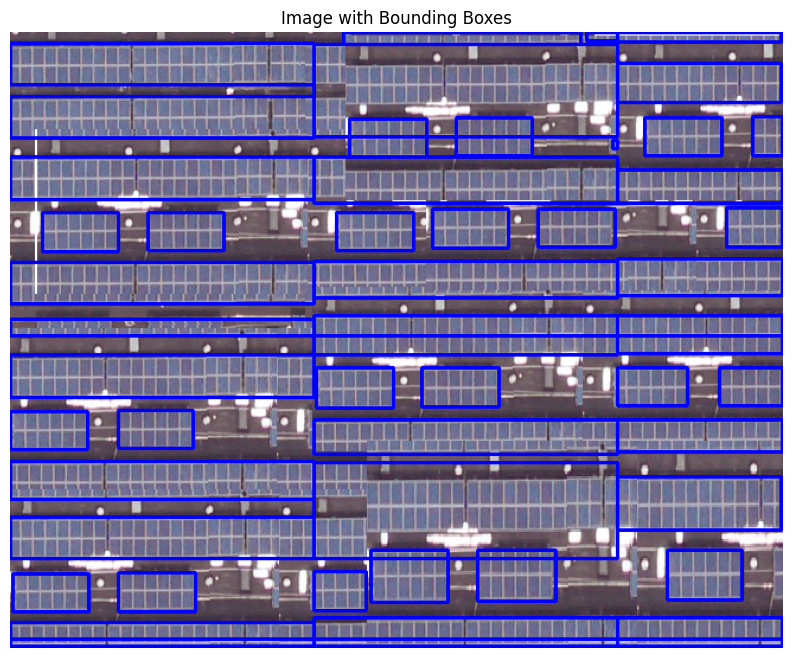

Total area selected: 230664 pixels
Percentage of image selected: 68.03%


In [15]:
# Define helper functions
def slice_image(image, patch_size=256):
    patches = []
    positions = []  # To store the (x, y) positions of each patch
    height, width = image.shape[:2]
    
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            # Handle edge patches by padding
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                pad_bottom = patch_size - patch.shape[0]
                pad_right = patch_size - patch.shape[1]
                patch = cv2.copyMakeBorder(
                    patch, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=0
                )
            patches.append(patch)
            positions.append((x, y))
    return patches, positions

def compute_bboxes(image, pred_mask):
    kernel = np.ones((5, 5), np.uint8)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    labeled = km.label(pred_mask)
    props = km.regionprops(labeled)
    bboxes = set([p.bbox for p in props])
    return bboxes

def draw_bbox(image, bboxes):
    for box in bboxes:
        min_row, min_col, max_row, max_col = box
        # Ensure coordinates are integers
        top_left = (int(min_col), int(min_row))
        bottom_right = (int(max_col), int(max_row))
        # Draw rectangle
        image = cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)
    return image

# Main processing code
patches, positions = slice_image(selected_img)
height, width = selected_img.shape[:2]
all_bboxes = []

for i, patch in enumerate(patches):
    # Preprocess the patch
    preprocessed_patch = imgread_preprocessing(patch)
    image_torch = torch.from_numpy(preprocessed_patch).to(device).unsqueeze(0)
    
    # Predict the mask for the patch
    pr_mask = model(image_torch)
    pr_mask = pr_mask.squeeze().detach().cpu().numpy().round().astype(np.uint8)
    
    # Compute bounding boxes in the patch
    bboxes = compute_bboxes(patch, pr_mask)
    
    # Get the position of this patch in the original image
    x_offset, y_offset = positions[i]
    
    # Adjust bounding boxes to original image coordinates
    adjusted_bboxes = []
    for bbox in bboxes:
        min_row, min_col, max_row, max_col = bbox
        # Adjust the coordinates
        adjusted_bbox = (min_row + y_offset, min_col + x_offset, max_row + y_offset, max_col + x_offset)
        adjusted_bboxes.append(adjusted_bbox)
    
    # Collect the adjusted bounding boxes
    all_bboxes.extend(adjusted_bboxes)

# Draw all bounding boxes on the original image
image_with_bboxes = selected_img.copy()
image_with_bboxes = draw_bbox(image_with_bboxes, all_bboxes)

# Display the image with bounding boxes
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB))
plt.title('Image with Bounding Boxes')
plt.axis('off')
plt.show()

# Calculate total area selected (optional)
total_area_selected = 0
for bbox in all_bboxes:
    min_row, min_col, max_row, max_col = bbox
    area = (max_row - min_row) * (max_col - min_col)
    total_area_selected += area

total_image_area = height * width
percentage_selected = (total_area_selected / total_image_area) * 100
print(f"Total area selected: {total_area_selected} pixels")
print(f"Percentage of image selected: {percentage_selected:.2f}%")
